# Kelompok 2


1. Christina Putri Hutahaean
2. ⁠Muhammad Daffin Salman Mumtaz
3. Dava Gilang Maulana
4. Javanka Amedeo Cavendish
5. ⁠Muhammad Tedy Assadulhaq Qurota A'yun
6. Ahmad Yazid Isnandar
7. Dinda Rahma Juwita
8. Fikri Arif Rahman


In [1]:
pip install librosa

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os
import glob
import zipfile
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [13]:
# Function to extract features from audio files
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_features = {f'mfcc_{i}': np.mean(mfcc[i]) for i in range(mfcc.shape[0])}

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_features = {f'chroma_{i}': np.mean(chroma[i]) for i in range(chroma.shape[0])}

        # Mel-scaled spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_features = {f'mel_{i}': np.mean(mel[i]) for i in range(mel.shape[0])}

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_features = {f'contrast_{i}': np.mean(contrast[i]) for i in range(contrast.shape[0])}

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_features = {'zcr': np.mean(zcr)}

        # RMS (Root Mean Square) Energy
        rms = librosa.feature.rms(y=y)
        rms_features = {'rms': np.mean(rms)}

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_bandwidth_features = {'spectral_bandwidth': np.mean(spectral_bandwidth)}

        # Combine all features into one dictionary
        features = {**mfcc_features, **chroma_features, **mel_features, **contrast_features, **zcr_features, **rms_features, **spectral_bandwidth_features}

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [15]:

# Define path to the zip file
zip_path = '/content/drive/MyDrive/musikklasifkasi.zip'

# Extract the zip file
extracted_path = '/content/drive/MyDrive/Musikemosi/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Define paths for each emotion category based on extracted folders
paths = {
    'Aggressive': os.path.join(extracted_path, 'aggressive/*.wav'),
    'Dramatic': os.path.join(extracted_path, 'dramatic/*.wav'),
    'Happy': os.path.join(extracted_path, 'happy/*.wav'),
    'Romantic': os.path.join(extracted_path, 'romantic/*.wav'),
    'Sad': os.path.join(extracted_path, 'sad/*.wav')
}

In [16]:
# Count and print the number of files in each category
for emotion, path_pattern in paths.items():
    num_files = len(glob.glob(path_pattern))
    print(f"Number of '{emotion}' files: {num_files}")

Number of 'Aggressive' files: 500
Number of 'Dramatic' files: 500
Number of 'Happy' files: 500
Number of 'Romantic' files: 500
Number of 'Sad' files: 500


In [17]:
# Dictionary to store audio data
audio_data = {}

# Load audio files for each emotion category with a maximum limit of 1000 files
for emotion, path_pattern in paths.items():
    audio_files = glob.glob(path_pattern)[:500]
    audio_data[emotion] = audio_files
    print(f"Number of '{emotion}' files loaded: {len(audio_files)}")

Number of 'Aggressive' files loaded: 500
Number of 'Dramatic' files loaded: 500
Number of 'Happy' files loaded: 500
Number of 'Romantic' files loaded: 500
Number of 'Sad' files loaded: 500


In [18]:
# Extract features for each audio file in emotion categories
all_features = []

for emotion, file_paths in audio_data.items():
    for file_path in file_paths:
        features = extract_features(file_path)
        if features is not None:
            features['filename'] = os.path.basename(file_path)
            features['label'] = emotion
            all_features.append(features)

# Create DataFrame from all features
if all_features:
    df = pd.DataFrame(all_features)
else:
    print("No features were extracted.")


In [20]:
# One-Hot Encoding for labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['label'])
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
df_encoded = pd.concat([df.drop('label', axis=1), pd.DataFrame(onehot_encoded, columns=label_encoder.classes_)], axis=1)

# Scaling features with Standard Scaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded.drop(['filename'], axis=1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, onehot_encoded, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [21]:
# Define the model builder function for Keras Tuner
def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [22]:

# Initialize the tuner
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dataasli',
    project_name='data_asli')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])


Trial 5 Complete [00h 00m 38s]
val_accuracy: 0.9991666674613953

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 50s


In [25]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Train the best model with early stopping and model checkpoint
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 320)               62720     
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 320)               102720    
                                                                 
 dropout_1 (Dropout)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1605      
                                                                 
Total params: 167045 (652.52 KB)
Trainable params: 167045 (652.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/50
50/50 [==============================] - 3s 23ms/step - loss: 0.0155 - accuracy: 0.9969 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 2/50
 6/50 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 1s 14ms/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000
Test accuracy: 1.0


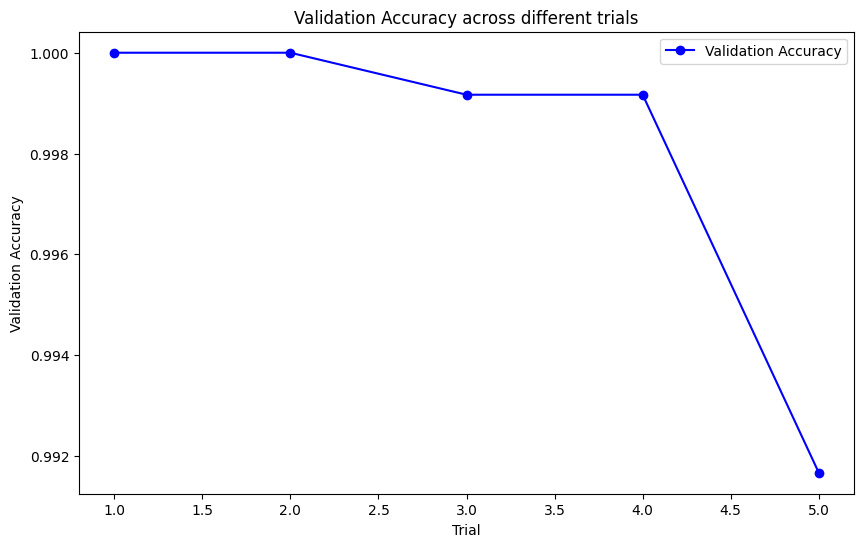

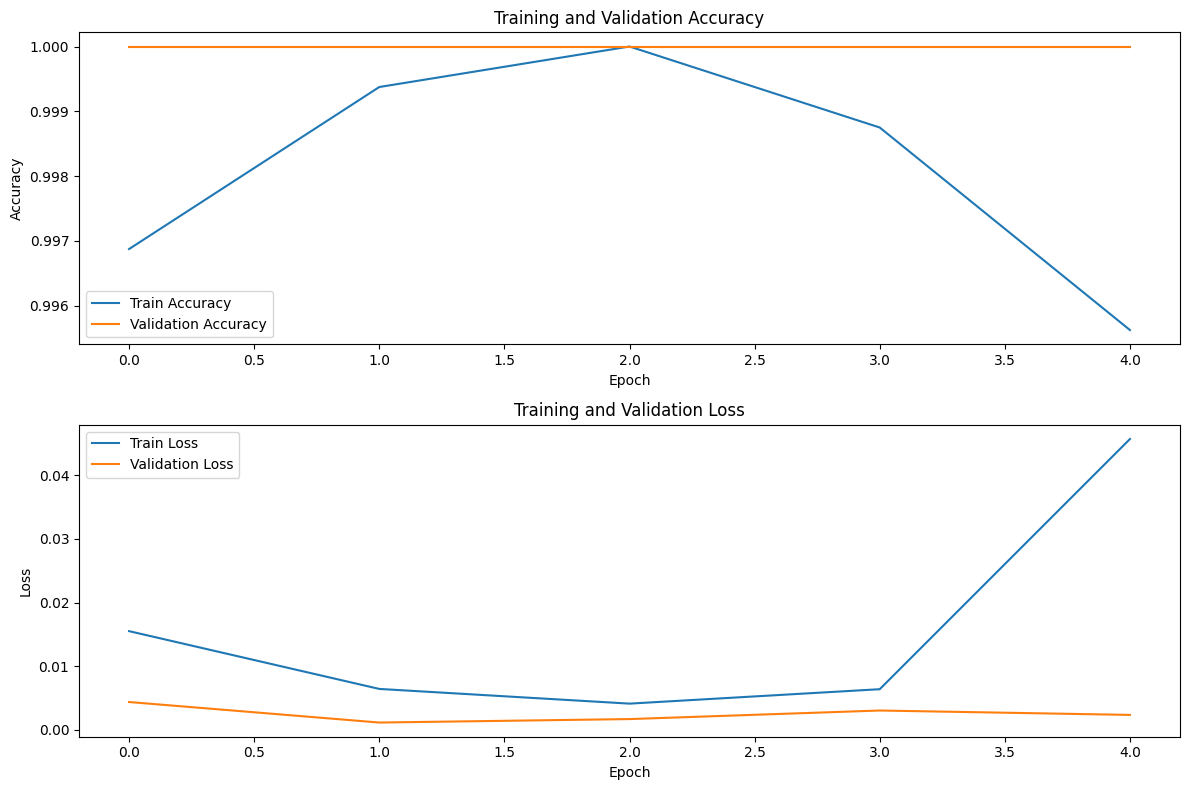

In [27]:
# Retrieve the best performing trials
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Plot the validation accuracy of each trial
val_accuracies = [trial.metrics.get_best_value('val_accuracy') for trial in tuner_results]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'bo-', label='Validation Accuracy')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy across different trials')
plt.legend()
plt.show()

# Plot training history: accuracy and loss for both training and validation
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

16/16 [==============================] - 0s 4ms/step
Accuracy: 100.00%


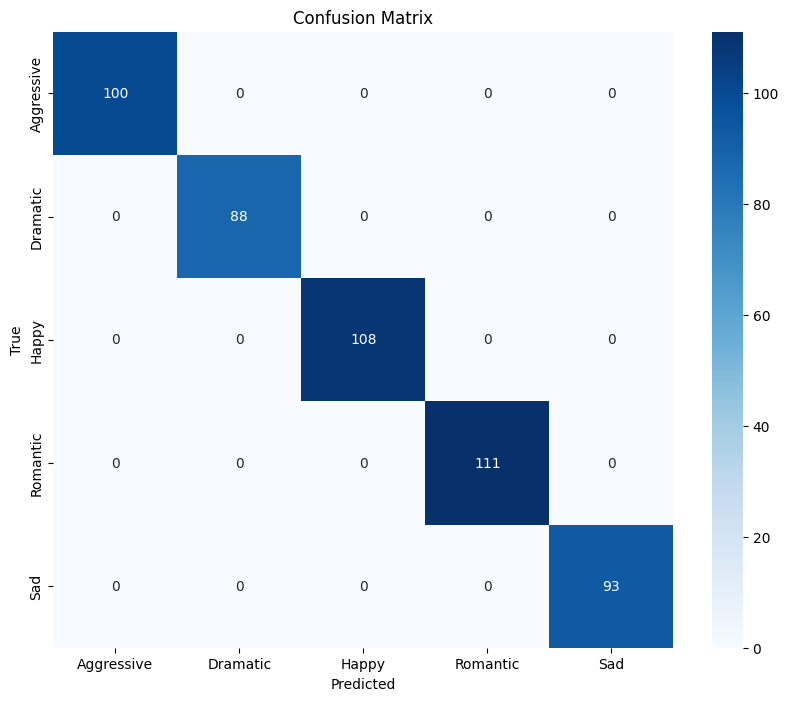

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict the labels for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate the accuracy
acc = accuracy_score(y_true_classes, y_pred_classes)
print(f'Accuracy: {acc * 100:.2f}%')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [55]:
# Save the trained model
best_model.save('musikemosi.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
pip install pydub

In [56]:
from IPython.display import Audio
from pydub import AudioSegment
import os

def convert_and_trim_audio_to_wav(input_path, output_path, duration_ms=5000):
    """
    Convert OGG, MP3, or MPEG to WAV and trim to the first 5 seconds.

    Parameters:
    input_path (str): Path to the input OGG, MP3, or MPEG file.
    output_path (str): Path to save the output WAV file.
    duration_ms (int): Duration in milliseconds to trim the audio. Default is 5000 ms (5 seconds).
    """
    # Determine the file extension
    file_extension = os.path.splitext(input_path)[1].lower()

    # Load the audio file based on its format
    if file_extension == '.ogg':
        audio = AudioSegment.from_ogg(input_path)
    elif file_extension == '.mp3' or file_extension == '.mpeg':
        audio = AudioSegment.from_mp3(input_path)
    else:
        raise ValueError("Unsupported file format: Only .ogg, .mp3, and .mpeg files are supported")

    # Trim audio to the specified duration
    trimmed_audio = audio[:duration_ms]

    # Export the trimmed audio to WAV format
    trimmed_audio.export(output_path, format="wav")

# File paths
input_file_path = '/content/WhatsApp Audio 2024-05-21 at 9.38.20 AM.mpeg'  # Replace with your input file path
output_file_path = 'temp5.wav'

# Convert and trim the audio
convert_and_trim_audio_to_wav(input_file_path, output_file_path)

# Play the trimmed audio
Audio(output_file_path)


In [50]:
# Function to preprocess and extract features from a new audio file
def preprocess_and_extract_features(file_path):
    features = extract_features(file_path)
    if features is not None:
        # Create DataFrame from extracted features
        features_df = pd.DataFrame([features])
        # Scale features (excluding 'filename')
        scaled_features = scaler.transform(features_df)
        return scaled_features
    else:
        return None

In [57]:
# Function to preprocess and extract features from a new audio file
def preprocess_and_extract_features(file_path):
    features = extract_features(file_path)
    if features is not None:
        # Create DataFrame from extracted features
        features_df = pd.DataFrame([features])
        # Add dummy columns for missing features (one-hot encoded labels) to match scaler input
        for label in label_encoder.classes_:
            features_df[label] = 0
        # Scale features
        scaled_features = scaler.transform(features_df)
        return scaled_features
    else:
        return None

# Path to the new audio file
new_file_path = '/content/temp5.wav'

# Extract and preprocess features for the new audio file
new_audio_features = preprocess_and_extract_features(new_file_path)


In [58]:
if new_audio_features is not None:
    # Use the trained model to make a prediction
    prediction = best_model.predict(new_audio_features)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

    print(f"Predicted emotion for {os.path.basename(new_file_path)}: {predicted_label[0]}")
else:
    print("Failed to extract features from the new audio file.")

1/1 [==============================] - 0s 26ms/step
Predicted emotion for temp5.wav: Sad
